Plots win rate vs. varying adversary/victim visits.

In [38]:
%load_ext autoreload
%autoreload 2
import re

import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("2-col-neurips"),
        utils.get_style("small-legend"),
        {"ytick.left": True, "ytick.right": True},
    ]
)
utils.import_plt_sty("robustness-macros.sty")

def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[(df['b_name'].str.contains(player_substring)) | (df['w_name'].str.contains(player_substring))].copy()

def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = 'index == index or index != index',
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi

def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(
        custom_ylabel or f"Win \\% vs. {victim_label}"
    )
    plt.xlabel("Victim visits")
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

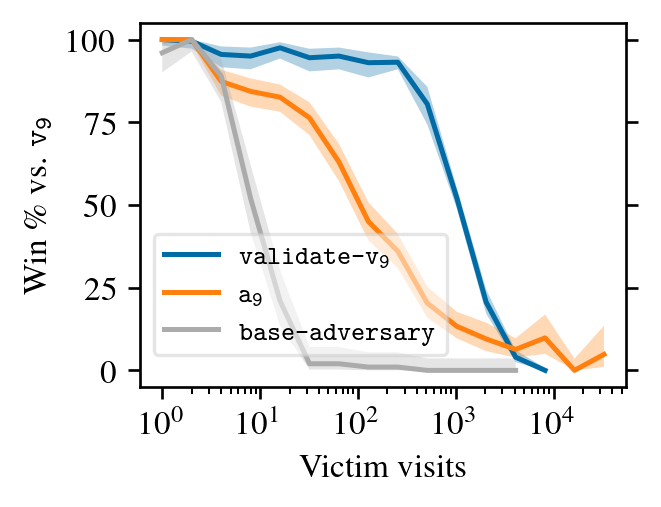

In [40]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-19"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\attackhnine{}"),
        (r9_df, r"\attackiter{9}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ], 
    r"\defenseiter{9}")
# Move legend and make transparent to increase visibility of plot lines
legend = ax.legend(loc="lower left", bbox_to_anchor=(0, .05))
legend.get_frame().set_alpha(0.5)
fig.savefig("vs-visits-h9.pgf", backend="pgf")

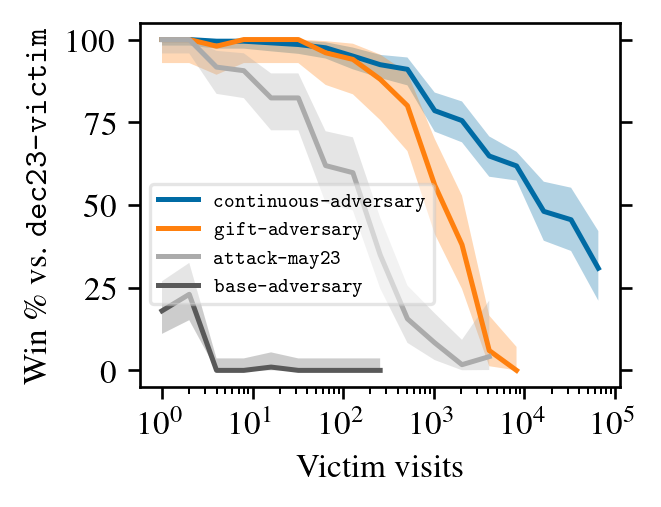

In [41]:
# cont_df = utils.parse_sgfs(
#     [
#         "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
#         "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
#         "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v16k-to-65k",
#     ]
# )
# cont_df = filter_df_for_player(cont_df, "b18")
# utils.parse_for_match(cont_df, adv_name_regex="cont")

# # TODO this data needs to be updated after running evals
# ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-prelim-240329/victim-visits"])
# utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

# cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/cyclic"])
# utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

# attack_b60_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/attack-b60"])
# utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\contadv{}"),
        (ko_df, r"\koadv{}"),
        (attack_b60_df, r"\attackbsixty{}"),
        (cyclic_df, r"\origcyclic{}"),
    ],
    r"\dectwentythree{}",
)
legend = ax.legend(loc="lower left", bbox_to_anchor=(0, .2), prop={'size': 6})
legend.get_frame().set_alpha(0.5)
fig.savefig("vs-visits-b18.pgf", backend="pgf")

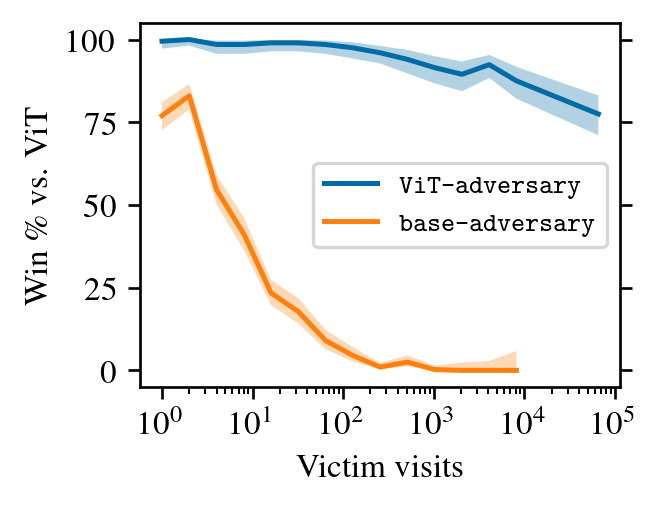

In [42]:
attack_vit_df = utils.parse_sgfs(["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"])
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"ViT",
)
fig.savefig("vs-visits-vit.pgf", backend="pgf")

attack_vit_xlim = ax.get_xlim()

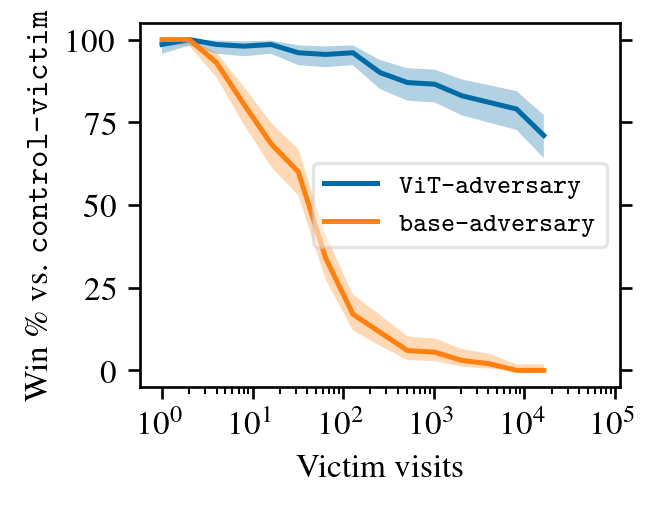

In [43]:
df = utils.parse_sgfs(["/shared/match/attack-b10-240311"])
attack_vit_df = filter_df_for_player(df, "attack-vit")
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")
original_cyclic_df = filter_df_for_player(df, "cyclic")
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"\controlbten{}",
)
# keep x-axis the same as ViT plot for easier visual comparison
ax.set_xlim(*attack_vit_xlim)
ax.legend().get_frame().set_alpha(0.5)
fig.savefig("vs-visits-control-b10.pgf", backend="pgf")